# Genome Size Analysis
### Assembled genome size (bp) per MAG, compared across sequencing techniques

This notebook documents the workflow used to:

- Load and validate `Metadata_Extended.tsv`
- Summarize **MAG yield per sample** (counts) across sequencing techniques
- Compute **assembled genome size** (bp) per MAG by summing contig lengths in each MAG FASTA
- Compare genome-size distributions between **Illumina** and **PacBio**
- Export merged tables for downstream analyses (e.g., QIIME2 / diversity workflows)

#### **Goal**

**Quantify and compare reconstructed MAG properties between sequencing techniques**  
(specifically: *MAG yield per sample* and *assembled genome size per MAG*).

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold;">
Note: Some commands (e.g., downloading data archives) are kept in the notebook but may be commented out depending on your environment.  
Genome-size computation scans FASTA files on disk (default: <code>data/raw</code>, fallback: <code>data/</code>).  
If your MAG FASTA files live elsewhere, update <code>SEARCH_ROOTS</code> in <b>Step 3</b>.
</div>

#### **Notebook Content:** ####
- [Prepare Environment](#prepare-environment)
- [Load and Validate Metadata](#step-1-load-and-validate-metadata)
- [MAG Yield per Sample](#step-2-mag-yield-per-sample)
- [Compute Genome Size from FASTA](#step-3-compute-genome-size-from-fasta)
- [QC + Merge](#step-4-qc--merge)
- [Summaries](#step-5-summaries)
- [Visualizations](#step-6-visualizations)
- [Exports](#step-7-exports)

### **The workflow** ###

1. **Prepare environment** (imports, folders, optional data download)
2. **Load and validate metadata** (`sample-id`, `sample`, `mag-id`)
3. **Summarize MAG yield per sample** (and whether samples were sequenced by both techniques)
4. **Compute genome sizes** from MAG FASTA files
5. **QC + merge** genome-size results back into metadata
6. **Summarize + visualize** distributions (log-scale options)
7. **Export** merged tables / summary outputs

### Prepare Environment

#### Import Packages

In [1]:
#set up environment
import os
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
from qiime2 import Visualization
import qiime2 as q2

%matplotlib inline
import matplotlib.pyplot as plt

# create directories for the notebook. DO NOT change
data_dir = "data/01.3_Genome_size"
raw_data = "data/raw"
metadata_dir = "data/processed/metadata"
out_dir = Path(data_dir)

!mkdir -p data
!mkdir -p $raw_data
!mkdir -p $metadata_dir
!mkdir -p $data_dir

# fetches useful files for the current notebook. All files will be saved in `data/`
!wget 'https://polybox.ethz.ch/index.php/s/nMa2WaWEDft3kMr/download' -O data/Download.zip
!unzip -o data/Download.zip -d data
!rm data/Download.zip

--2025-12-12 22:04:44--  https://polybox.ethz.ch/index.php/s/nMa2WaWEDft3kMr/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278 [application/zip]
Saving to: ‘data/Download.zip’

data/Download.zip   100%[===================>]     278  --.-KB/s    in 0s      

2025-12-12 22:04:44 (202 MB/s) - ‘data/Download.zip’ saved [278/278]

Archive:  data/Download.zip


### Step 1. Load and validate metadata

We load the project metadata table (generated in earlier preprocessing).  
Downstream steps assume at least these columns exist:

- `sample-id` (e.g., `IL_...` / `PB_...`)
- `sample` (biological sample identifier)
- `mag-id` (MAG identifier used in FASTA filenames)

In [2]:
# Load metadata (expected output of earlier preprocessing)
meta_path = Path(metadata_dir) / "Metadata_Extended.tsv"
if not meta_path.exists():
    raise FileNotFoundError(
        f"Metadata file not found: {meta_path}\n"
        "Make sure you downloaded/unzipped the project data and that metadata_dir is correct."
    )

metadata = pd.read_csv(meta_path, sep="\t")

required_cols = {"sample-id", "sample", "mag-id"}
missing = sorted(required_cols - set(metadata.columns))
if missing:
    raise ValueError(f"Metadata_Extended.tsv is missing required columns: {missing}")

metadata[list(required_cols)].head(3)


,sample-id,mag-id,sample
0,PB_B039_Aa_Gp_La,bd5e2c58-6dec-4993-adc2-b151d4ddc9f6,B039_Aa_Gp_La
1,PB_B039_Aa_Gp_La,beb82fa3-c540-4533-b671-2051e1db6045,B039_Aa_Gp_La
2,PB_B039_Aa_Gp_La,1ed3197e-829e-44e0-a77b-41fa76efbabb,B039_Aa_Gp_La


### Step 2. MAG yield per sample

This section answers two quick “sanity” questions before we look at genome sizes:

- Do **Illumina** and **PacBio** produce different numbers of MAGs per sample?
- Are all biological samples (`sample`) sequenced by **both** techniques?

We infer sequencing technique from the `sample-id` prefix (`IL_` vs `PB_`).

In [3]:
# Helper shared across the notebook
def infer_technique(sample_id: str) -> str:
    """Infer sequencing technique from `sample-id` prefix."""
    s = str(sample_id).upper()
    if s.startswith("PB_"):
        return "PacBio"
    if s.startswith("IL_"):
        return "Illumina"
    return "Unknown"

meta = metadata.copy()
meta["sample-id"] = meta["sample-id"].astype(str).str.strip()
meta["sample"] = meta["sample"].astype(str).str.strip()
meta["mag-id"] = meta["mag-id"].astype(str).str.strip()

meta["technique"] = meta["sample-id"].map(infer_technique)

# Keep a clean metadata slice for downstream merges (one row per MAG entry)
base_meta = meta.loc[:, ["sample-id", "sample", "mag-id", "technique"]].copy()

# MAG yield per sequencing run (sample-id)
mags_per_run = (
    meta.groupby(["sample-id", "technique"])["mag-id"]
    .nunique()
    .reset_index(name="n_mags")
)

# MAG yield per biological sample (sample) + technique
mags_per_sample = (
    meta.groupby(["sample", "technique"])["mag-id"]
    .nunique()
    .reset_index(name="n_mags")
)

# Which biological samples have both techniques?
tech_by_sample = (
    mags_per_sample.groupby("sample")["technique"]
    .apply(lambda s: sorted(set(s)))
    .reset_index(name="techniques_present")
)
tech_by_sample["has_both"] = tech_by_sample["techniques_present"].apply(
    lambda xs: ("Illumina" in xs) and ("PacBio" in xs)
)

print("Biological samples (unique `sample`):", tech_by_sample.shape[0])
print("Sequenced by both techniques:", int(tech_by_sample["has_both"].sum()))
print("Only one technique:", int((~tech_by_sample["has_both"]).sum()))

mags_per_sample.head(5)

Biological samples (unique `sample`): 33
Sequenced by both techniques: 19
Only one technique: 14


,sample,technique,n_mags
0,36fe4,PacBio,8
1,3ee22,PacBio,4
2,9b8b5,PacBio,6
3,A001,Illumina,29
4,A001,PacBio,112


### Step 3. Compute genome size from FASTA

We compute **assembled genome size (bp)** by summing contig lengths in each MAG FASTA.

**Matching rule (robust + simple):**
- FASTA filename begins with `mag-id` from metadata (exact match or prefix + separator)
- `sample-id` is inferred from the directory tree (exact match / regex extraction / `sample` name fallback)

If you have multiple FASTA candidates for the same `(sample-id, mag-id)`, we keep the **largest file**.

In [4]:
from pathlib import Path
from typing import Optional
import gzip
import re

import pandas as pd

# Step 3. Compute genome size from FASTA
# We scan FASTA files under SEARCH_ROOTS and compute assembled size (bp) per MAG.
# Matching:
#   - FASTA filename begins with a metadata `mag-id` (exact or prefix + separator)
#   - `sample-id` is inferred from the directory tree

FASTA_PATTERNS = ("*.fa", "*.fna", "*.fasta", "*.fa.gz", "*.fna.gz", "*.fasta.gz")

# Prefer Setup-defined `raw_data` (often data/raw). Fall back to data/ if needed.
SEARCH_ROOTS = [Path(raw_data), Path("data")]

# --- Light-weight helpers ------------------------------------------------

if "infer_technique" not in globals():
    def infer_technique(sample_id: str) -> str:
        """Infer sequencing technique from `sample-id` prefix."""
        s = str(sample_id).upper()
        if s.startswith("PB_"):
            return "PacBio"
        if s.startswith("IL_"):
            return "Illumina"
        return "Unknown"

# Trim whitespace early: most FASTA/metadata mismatches come from invisible spaces.
meta = metadata.loc[:, ["sample-id", "sample", "mag-id"]].copy()
meta["sample-id"] = meta["sample-id"].astype(str).str.strip()
meta["sample"] = meta["sample"].astype(str).str.strip()
meta["mag-id"] = meta["mag-id"].astype(str).str.strip()

sample_id_set = set(meta["sample-id"])
mag_id_set = set(meta["mag-id"])

# Some folder structures use `sample` rather than `sample-id`; allow a safe fallback only when unambiguous.
sample_to_sample_ids = (
    meta.groupby("sample")["sample-id"]
    .apply(lambda s: sorted(set(s)))
    .to_dict()
)

_SAMPLE_ID_RE = re.compile(r"^(PB|IL)_[A-Za-z0-9]+", re.IGNORECASE)
_BOUNDARY = set("._-")  # common separators after mag-id in filenames

# Pre-compute mag-id lengths for fast prefix checks (avoids scanning all mag-ids per file).
_mag_lens = sorted({len(m) for m in mag_id_set}, reverse=True)

def _strip_fasta_suffix(filename: str) -> str:
    """Remove .gz and FASTA extension; return the remaining basename."""
    base = filename
    if base.endswith(".gz"):
        base = base[:-3]
    for ext in (".fa", ".fna", ".fasta"):
        if base.endswith(ext):
            base = base[: -len(ext)]
            break
    return base

def match_mag_id_from_file(path: Path) -> Optional[str]:
    """Return matched metadata `mag-id` if filename begins with it; else None."""
    base = _strip_fasta_suffix(path.name)

    # Exact: filename == mag-id
    if base in mag_id_set:
        return base

    # Prefix + boundary: mag-id + ('_', '.', '-') + anything
    for L in _mag_lens:
        if len(base) < L:
            continue
        prefix = base[:L]
        if prefix in mag_id_set and (len(base) == L or base[L] in _BOUNDARY):
            return prefix
    return None

def infer_sample_id_from_path(path: Path) -> Optional[str]:
    """Infer `sample-id` from directory components (exact match / regex / sample-name fallback)."""
    # 1) Exact match against metadata sample-ids
    for part in path.parts[::-1]:
        part = str(part)
        if part in sample_id_set:
            return part

    # 2) Regex extraction (PB_/IL_...) if the folder name contains more text
    for part in path.parts[::-1]:
        m = _SAMPLE_ID_RE.match(str(part))
        if m:
            cand = m.group(0)
            if cand in sample_id_set:
                return cand

    # 3) Folder equals `sample` name (only if it maps to a single sample-id)
    for part in path.parts[::-1]:
        p = str(part)
        if p in sample_to_sample_ids and len(sample_to_sample_ids[p]) == 1:
            return sample_to_sample_ids[p][0]

    return None

def fasta_bp(path: Path) -> int:
    """Sum sequence lengths in a FASTA (supports .gz); ignores headers."""
    opener = gzip.open if path.suffix == ".gz" else open
    total = 0
    with opener(path, "rt") as fh:
        for line in fh:
            if not line or line.startswith(">"):
                continue
            total += len(line.strip())
    return int(total)

# 1) Collect candidates, keep best FASTA per (sample-id, mag-id)
best = {}
orphan_hits = []  # (mag-id, path) where sample-id couldn't be inferred

for root in SEARCH_ROOTS:
    if not root.exists():
        continue

    for pat in FASTA_PATTERNS:
        for fp in root.rglob(pat):
            mag_id = match_mag_id_from_file(fp)
            if mag_id is None:
                continue

            sample_id = infer_sample_id_from_path(fp)
            if sample_id is None:
                orphan_hits.append((mag_id, str(fp)))
                continue

            key = (sample_id, mag_id)

            # If duplicates exist, keep the largest file on disk (usually the final MAG FASTA).
            try:
                cur_size = fp.stat().st_size
            except OSError:
                cur_size = -1

            prev = best.get(key)
            if prev is None:
                best[key] = fp
            else:
                try:
                    prev_size = prev.stat().st_size
                except OSError:
                    prev_size = -1
                if cur_size > prev_size:
                    best[key] = fp

if orphan_hits:
    print(
        f"Note: {len(orphan_hits)} FASTA hits matched a metadata mag-id but sample-id couldn't be inferred from the path.\n"
        "      They will be ignored for merging because we merge on (sample-id, mag-id)."
    )

# 2) Compute genome sizes (bp) for selected FASTA files
rows = []
for (sample_id, mag_id), fp in sorted(best.items()):
    rows.append(
        {
            "sample-id": sample_id,
            "mag-id": mag_id,
            "technique_gs": infer_technique(sample_id),
            "size_bp": fasta_bp(fp),
            "fasta_path": str(fp),
        }
    )

genome_sizes = pd.DataFrame(rows)
print("Computed genome sizes for (sample-id, mag-id) pairs:", len(genome_sizes))
genome_sizes.head()

Computed genome sizes for (sample-id, mag-id) pairs: 1426


,sample-id,mag-id,technique_gs,size_bp,fasta_path
0,IL_A001,05de661d-1268-4a70-837b-62b875c2e1f9,Illumina,2013774,data/raw/sample_data/IL_A001/05de661d-1268-4a7...
1,IL_A001,06407f08-c6a1-4a67-8f74-db44f502516c,Illumina,1304023,data/raw/sample_data/IL_A001/06407f08-c6a1-4a6...
2,IL_A001,2cd91a3b-27e8-4763-b6ac-b092a42a0af3,Illumina,617764,data/raw/sample_data/IL_A001/2cd91a3b-27e8-476...
3,IL_A001,37a9af16-1419-46b3-9bd1-c0f2274fab22,Illumina,208655,data/raw/sample_data/IL_A001/37a9af16-1419-46b...
4,IL_A001,47dae4f0-0bea-45a9-b0d9-35aa9ac915dd,Illumina,1636607,data/raw/sample_data/IL_A001/47dae4f0-0bea-45a...


### Step 4. QC + merge

In [5]:
# Step 4. QC + merge (do not modify metadata in-place)

# Basic sanity check: if this is empty, the FASTA scan didn't match metadata.
if genome_sizes.empty:
    raise RuntimeError(
        "No FASTA files matched metadata (sample-id + mag-id).\n"
        "Double-check SEARCH_ROOTS and whether FASTA filenames start with mag-id."
    )

print("technique_gs (from FASTA inference) value_counts:")
print(genome_sizes["technique_gs"].value_counts(dropna=False))

# Quick diagnostic: do we at least overlap in mag-id space?
meta_mags = set(metadata["mag-id"].astype(str).str.strip())
gs_mags = set(genome_sizes["mag-id"].astype(str).str.strip())
inter = len(meta_mags & gs_mags)
print("\nmag-id intersection:", inter, "/", len(meta_mags), "(metadata)")

if inter == 0:
    raise RuntimeError(
        "No overlap between FASTA-derived mag-ids and metadata mag-ids.\n"
        "This usually means you're scanning the wrong folder, or FASTA filenames don't begin with mag-id."
    )

# Merge on a copy to keep shared objects unchanged.
base_meta = metadata.copy()
base_meta["sample-id"] = base_meta["sample-id"].astype(str).str.strip()
base_meta["mag-id"] = base_meta["mag-id"].astype(str).str.strip()

gs = genome_sizes.copy()
gs["sample-id"] = gs["sample-id"].astype(str).str.strip()
gs["mag-id"] = gs["mag-id"].astype(str).str.strip()

# Keep only the columns that will be used downstream.
metadata_gs = base_meta.merge(
    gs[["sample-id", "mag-id", "technique_gs", "size_bp"]],
    on=["sample-id", "mag-id"],
    how="left",
    validate="one_to_one",
)

print("metadata_gs rows:", len(metadata_gs))
print("Missing size_bp:", int(metadata_gs["size_bp"].isna().sum()))

technique_gs (from FASTA inference) value_counts:
technique_gs
PacBio      882
Illumina    544
Name: count, dtype: int64

mag-id intersection: 1426 / 1426 (metadata)
metadata_gs rows: 1426
Missing size_bp: 0


### Step 5. Summaries

In [6]:
# Step 5. Summaries

# One row per MAG with a computed size.
df_mag = (
    metadata_gs
    .dropna(subset=["size_bp", "technique_gs"])
    .loc[:, ["mag-id", "sample-id", "sample", "technique_gs", "size_bp"]]
    .copy()
)

if df_mag.empty:
    raise RuntimeError("No MAGs with `size_bp` available after merge. Check Step 3/4 matching.")

df_mag["size_kbp"] = df_mag["size_bp"] / 1e3

# Stable ordering for plots (preferred: Illumina then PacBio).
preferred = ["Illumina", "PacBio"]
tech_order = [t for t in preferred if t in set(df_mag["technique_gs"])]
tech_order += [t for t in sorted(df_mag["technique_gs"].unique()) if t not in tech_order]

summary = (
    df_mag.groupby("technique_gs")["size_kbp"]
    .agg(
        n="count",
        mean="mean",
        median="median",
        q25=lambda s: s.quantile(0.25),
        q75=lambda s: s.quantile(0.75),
        min="min",
        max="max",
    )
    .reindex(tech_order)
    .round(2)
)

summary

# Optional QC: inspect extremes (smallest / largest assembled MAGs)
df_mag.sort_values("size_bp").head(10)

df_mag.sort_values("size_bp", ascending=False).head(10)

,mag-id,sample-id,sample,technique_gs,size_bp,size_kbp
1101,a469929e-30e2-42d5-a84d-d1c2f864a3e3,IL_MS009-2,MS009-2,Illumina,105229916,105229.916
493,a5f8b31b-976b-4f9d-bf08-b7628fcede20,PB_P001,P001,PacBio,26029257,26029.257
1095,0f451561-3faa-4606-bcfc-25debaeb1706,IL_MS009-2,MS009-2,Illumina,15812886,15812.886
49,0652e2fd-1c49-402e-9c93-1bf079a68559,PB_9b8b5,9b8b5,PacBio,15776395,15776.395
694,32743463-7209-4b20-bfbc-b7ad67d498f9,PB_MS003-2,MS003-2,PacBio,14783991,14783.991
441,e7fb9bd2-9ce4-4291-86f5-d34c673b4f78,PB_M009,M009,PacBio,13366138,13366.138
1091,d0e91b6f-70f4-4ae5-9d5f-eef156c1c4b2,IL_B044_Hb_Ac_Ab,B044_Hb_Ac_Ab,Illumina,11125642,11125.642
465,be30f52c-b79d-4738-9870-809fb7e55e87,PB_M009,M009,PacBio,10747186,10747.186
450,7f424d0d-ffb2-4168-b768-b4c4d9f2868c,PB_M009,M009,PacBio,10629085,10629.085
1186,c97cad8f-3b2a-4c06-9e08-c102e1c3ed7c,IL_B056_Sc_Na_Af,B056_Sc_Na_Af,Illumina,10456576,10456.576


### Step 6. Visualizations

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

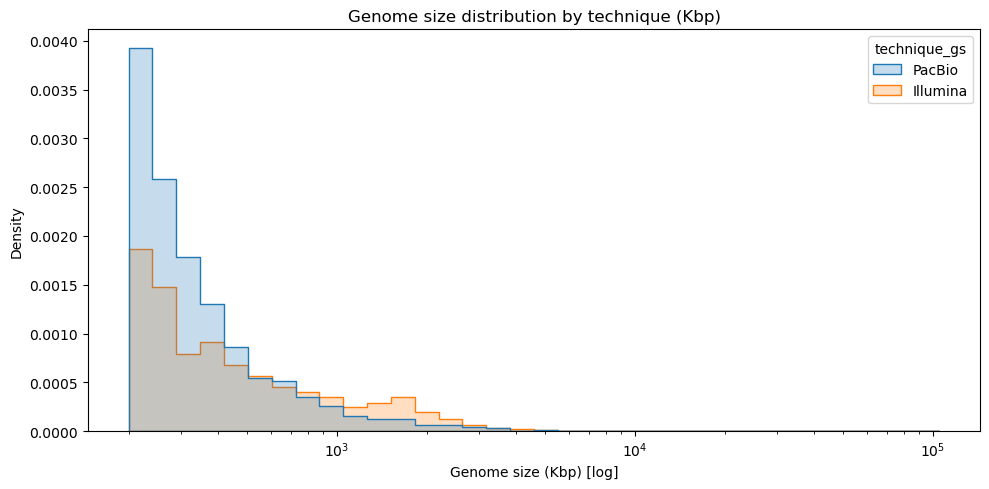

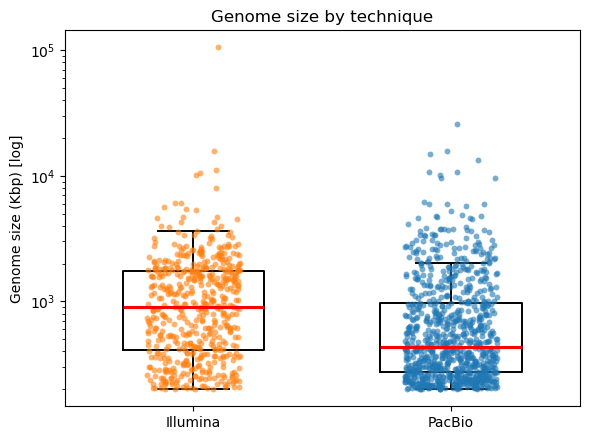

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


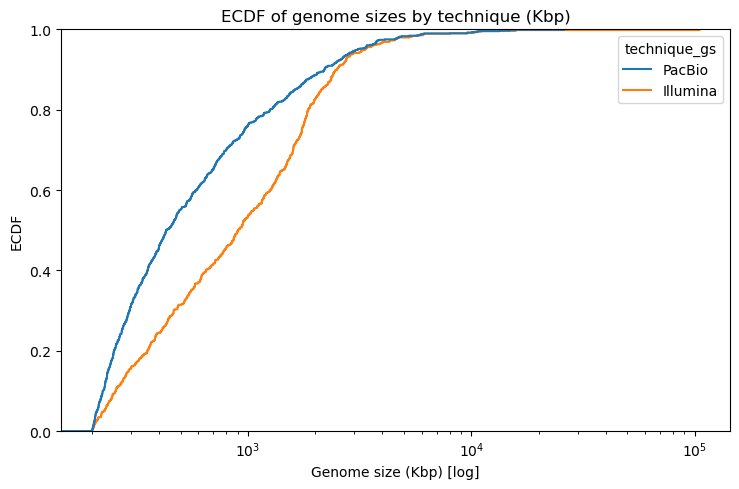

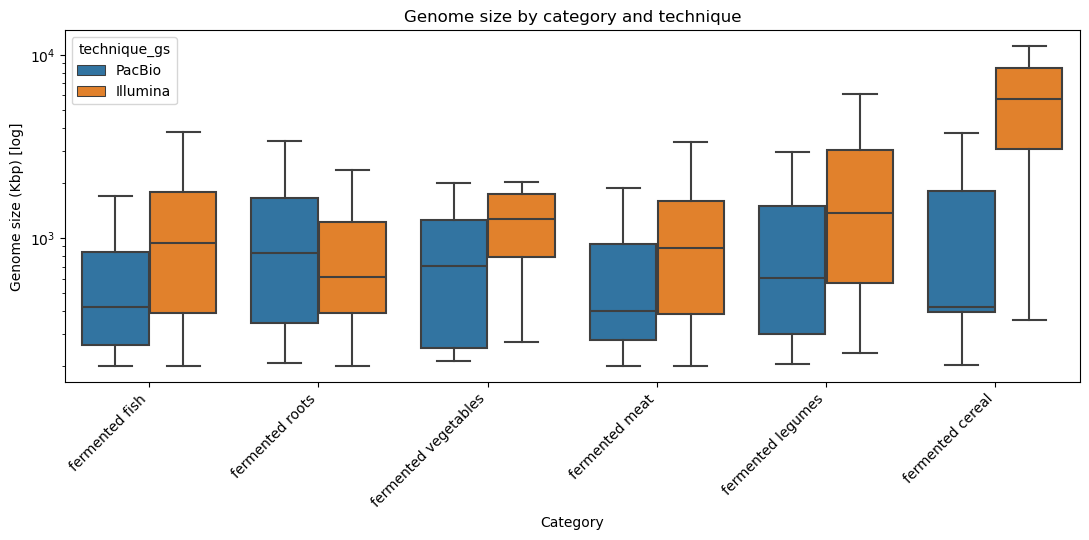

In [7]:
# Step 6. Visualizations

# -----------------------------
# 6.1 Genome size distributions
# -----------------------------
LOG = True            # log scale where applicable
FOCUS_MAX_KBP = None  # e.g. 1000 to zoom into <= 1000 Kbp

df_plot = df_mag.copy()
if FOCUS_MAX_KBP is not None:
    df_plot = df_plot.loc[df_plot["size_kbp"] <= FOCUS_MAX_KBP].copy()

# Histogram (density) — log-bins make size distributions easier to compare
x = df_plot["size_kbp"].to_numpy()
x_pos = x[x > 0]
bins = (
    np.logspace(np.log10(x_pos.min()), np.log10(x_pos.max()), 35)
    if LOG and x_pos.size and x_pos.max() > x_pos.min()
    else 35
)

plt.figure(figsize=(10, 5))
sns.histplot(
    data=df_plot,
    x="size_kbp",
    hue="technique_gs",
    element="step",
    stat="density",
    common_norm=False,
    bins=bins,
)
if LOG:
    plt.xscale("log")
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("Density")
plt.title("Genome size distribution by technique (Kbp)")
plt.tight_layout()
plt.show()

# 2) Boxplot + jittered points
plt.figure(figsize=(6, 4.5))

data = [df_mag.loc[df_mag["technique_gs"] == t, "size_kbp"].dropna().values
        for t in tech_order]

# --- boxplot (no color) ---
bp = plt.boxplot(
    data,
    labels=tech_order,
    showfliers=False,
    widths=0.55,
    medianprops=dict(color="red", linewidth=2.2),
    boxprops=dict(linewidth=1.4),
    whiskerprops=dict(linewidth=1.4),
    capprops=dict(linewidth=1.4),
)

for med in bp["medians"]:
    med.set_zorder(10)

# --- overlay points (jitter, colored) ---
rng = np.random.default_rng(0)
color_map = {"PacBio": "C0", "Illumina": "C1"}

for i, t in enumerate(tech_order, start=1):
    y = df_mag.loc[df_mag["technique_gs"] == t, "size_kbp"].dropna().values
    if y.size == 0:
        continue
    x = i + rng.uniform(-0.18, 0.18, size=y.size)
    plt.scatter(
        x, y,
        s=18, alpha=0.6, linewidths=0,
        color=color_map.get(t, "C2"),  # fallback color for unexpected labels
        zorder=2
    )

if LOG:
    plt.yscale("log")

plt.ylabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.title("Genome size by technique")
plt.tight_layout()
plt.show()



# ECDF
plt.figure(figsize=(7.5, 5))
sns.ecdfplot(data=df_plot, x="size_kbp", hue="technique_gs")
if LOG:
    plt.xscale("log")
plt.xlabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
plt.ylabel("ECDF")
plt.title("ECDF of genome sizes by technique (Kbp)")
plt.tight_layout()
plt.show()

# -----------------------------
# 6.2 Plot by sample category (if present in metadata)
# -----------------------------
if "category" in metadata_gs.columns:
    df_cat = (
        metadata_gs
        .dropna(subset=["size_bp", "technique_gs", "category"])
        .loc[:, ["category", "technique_gs", "size_bp"]]
        .copy()
    )
    df_cat["size_kbp"] = df_cat["size_bp"] / 1e3

    plt.figure(figsize=(11, 5.5))
    sns.boxplot(data=df_cat, x="category", y="size_kbp", hue="technique_gs", showfliers=False)
    if LOG:
        plt.yscale("log")
    plt.xlabel("Category")
    plt.ylabel("Genome size (Kbp)" + (" [log]" if LOG else ""))
    plt.title("Genome size by category and technique")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("Note: `category` column not found in metadata_gs — skipping category-based plot.")

### Step 7. Exports

In [8]:
# Step 7. Exports

out_dir.mkdir(parents=True, exist_ok=True)

# Core outputs
metadata_gs.to_csv(out_dir / "Metadata_Extended_with_genome_size.tsv", sep="\t", index=False)
genome_sizes.to_csv(out_dir / "genome_sizes_from_fasta.tsv", sep="\t", index=False)

# Summaries
summary.to_csv(out_dir / "genome_size_summary_by_technique.tsv", sep="\t")
mags_per_sample.to_csv(out_dir / "mag_yield_per_sample.tsv", sep="\t", index=False)
tech_by_sample.to_csv(out_dir / "sample_technique_coverage.tsv", sep="\t", index=False)

print("Wrote outputs to:", out_dir.resolve())
mags_per_run.to_csv(out_dir / "mag_yield_per_run.tsv", sep="\t", index=False)

Wrote outputs to: /home/jovyan/Interplanetary_Microbiome/data/01.3_Genome_size
